In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import clear_output

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import string
import re
from tqdm import notebook
from tqdm.auto import tqdm
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

# Helpers

In [2]:
def progress(done, left, start):
    # Print bar
    clear_output(wait=True)
    print(f"[{'#' * done}{' ' * left}] {round(done/(done+left) * 100, 2)}% ({done}/{done+left})")
    
    # Bereken gepasseerde tijd
    current = time.time()
    hours = int((current - start) // 3600)
    minutes = int((current - start) % 3600 // 60)
    seconds = int((current - start) % 60)
    
    # Print tijd
    print(f"""Time passed = {hours:02d}:{minutes:02d}:{seconds:02d}""")
    
    new_done = done + 1
    new_left = left - 1
    
    return new_done, new_left


# Laad data in

In [3]:
equal = pd.read_csv("../data/training_videos.csv").drop("Unnamed: 0", axis = 1)
equal["full_text"].fillna("", inplace=True)

equal.head()

,channel,video_id,conspiracy,full_text
0,UCyuAKnN3g2fZ7_R9irgEUZQ,SECdW8n4ZGw,False,abraham lincoln came power abraham lincoln com...
1,UCAtdV6VWa02UpCB2YHuVmHg,jSXIrZx8lI4,False,thanksgiv celebr announc union rescu mission n...
2,UCASQzDb4SUC0gZNPbwBubIQ,s0YjJVyyVjI,False,unc health s mobil clinic aim reduc racial eth...
3,UC_giJ3xlEL9jUF1YfJdzzuQ,VMHCvdRdq10,False,establish impur accept criteria part spec dmf ...
4,UCT8RMFbTJV5ILaVykrluOQg,KKiR4FWOZ4w,False,ten panda cub make public debut ahead spring f...


# Vectorize

In [4]:
# Vectorize words
v = TfidfVectorizer(max_df=.75, min_df=2)
x = v.fit_transform(equal['full_text'])

x

<44312x140970 sparse matrix of type '<class 'numpy.float64'>'
	with 23152699 stored elements in Compressed Sparse Row format>

In [5]:
x.shape

(44312, 140970)

In [35]:
X = x
Y = equal['conspiracy'].values.ravel()

# 10% of the data will be the test set
X_trainval, X_test, y_trainval, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1,\
                                                                                  random_state=0)

# of the remaining 90%, 90% will be training set
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_trainval, y_trainval,\
                                                                              train_size=0.9,\
                                                                              random_state=0)

# Hyperparameter tuning

## K-nearest neighbors

In [9]:
measures = {"K":[], "Accuracy":[], "Precision":[],"Recall":[], "F1":[]}

for k in notebook.tqdm(range(1, 16)):
    knn = KNeighborsClassifier(k).fit(X_train, y_train)

    y_pred = knn.predict(X_valid)

    measures["K"].append(k)
    measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, y_pred))
    measures["Precision"].append(sklearn.metrics.precision_score(y_valid, y_pred))
    measures["Recall"].append(sklearn.metrics.recall_score(y_valid, y_pred))
    measures["F1"].append(sklearn.metrics.f1_score(y_valid, y_pred))

df_knn = pd.DataFrame(measures)
df_knn.to_csv("k-nearest_neighbors.csv")

  0%|          | 0/15 [00:00<?, ?it/s]

## Neural Network

In [7]:
measures = {"Activation function":[], "# of hidden layers":[], "Neurons per layer":[],
            "Accuracy":[], "Precision":[],"Recall":[], "F1":[]}

done = 0
left = 4*3*3
start = time.time()

for act in ['identity', 'logistic', 'tanh', 'relu']:
    for layers in [1, 10, 25]:
        for neurons in [1, 10, 20]:
            # Progress bar
            done, left = progress(done, left, start)
            
            # Fit
            mlp = MLPClassifier(hidden_layer_sizes=[neurons]*layers, activation=act,\
                    random_state=0).fit(X_train, y_train)

            # Predict en sla waardes op
            y_pred = mlp.predict(X_test)
            measures["Activation function"].append(act)
            measures["# of hidden layers"].append(layers)
            measures["Neurons per layer"].append(neurons)
            
            measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, mlp.predict(X_valid)))
            measures["Precision"].append(sklearn.metrics.precision_score(y_valid, mlp.predict(X_valid)))
            measures["Recall"].append(sklearn.metrics.recall_score(y_valid, mlp.predict(X_valid)))
            measures["F1"].append(sklearn.metrics.f1_score(y_valid, mlp.predict(X_valid)))
            
done, left = progress(done, left, start)
            
df_nn = pd.DataFrame(measures)
df_nn.to_csv("neural_network.csv")

[################################### ] 97.22% (35/36)
Time passed = 08:18:00


## Support-vector machine

In [ ]:
measures = {"Kernel":[], "C":[], "Accuracy":[], "Precision":[], "Recall":[], "F1":[]}

done = 0
left = 4*4
start = time.time()

for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    for C in [0.1, 1, 10, 100]:       
        # Print progress
        done, left = progress(done, left, start)
        
        # Train
        svm = SVC(C=C, kernel=kernel, max_iter = 10000).fit(X_train, y_train)
        
        # Predict
        y_pred = svm.predict(X_valid)

        # Store
        measures["Kernel"].append(kernel)
        measures["C"].append(C)

        measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, y_pred))
        measures["Precision"].append(sklearn.metrics.precision_score(y_valid, y_pred))
        measures["Recall"].append(sklearn.metrics.recall_score(y_valid, y_pred))
        measures["F1"].append(sklearn.metrics.f1_score(y_valid, y_pred))
        
done, left = progress(done, left, start)
        
df_svm = pd.DataFrame(measures)
df_svm.to_csv("support-vector_machine.csv")

[                ] 0.0% (0/16)
Time passed = 00:00:00


## Logistic Regression

In [9]:
measures = {"Penalty":[], "C":[], "Solver":[], "Accuracy":[], "Precision":[],"Recall":[], "F1":[]}

done = 0
left = 4*3*3
start = time.time()

for solver in ['newton-cg', 'lbfgs', 'sag', 'saga']:
    for pen in ['l1', 'l2', 'none']:
        for C in [1, 10, 20]:
            try:
                # Print progress
                done, left = progress(done, left, start)
                
                # Train solver
                logr = LogisticRegression(penalty=pen, 
                                          C=C, 
                                          solver=solver,
                                          n_jobs=-1).fit(X_train, y_train)

                # Predict
                y_pred = logr.predict(X_valid)

                measures["Solver"].append(solver)
                measures["Penalty"].append(pen)
                measures["C"].append(C)

                measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, y_pred))
                measures["Precision"].append(sklearn.metrics.precision_score(y_valid, y_pred))
                measures["Recall"].append(sklearn.metrics.recall_score(y_valid, y_pred))
                measures["F1"].append(sklearn.metrics.f1_score(y_valid, y_pred))
            except:
                pass
            
done, left = progress(done, left, start)
            
df_logr = pd.DataFrame(measures)
df_logr.to_csv("logistic_regression.csv")

[################################### ] 97.22% (35/36)
Time passed = 00:20:07


## Ridge Classification

In [10]:
measures = {"Solver":[], "Alpha":[], "Accuracy":[], "Precision":[], "Recall":[], "F1":[]}

done = 0
left = 3*4
start = time.time()

for solver in ['auto', 'sparse_cg', 'sag']:
    for alpha in [0.1, 1, 10, 100]:
        # Print progress
        done, left = progress(done, left, start)
        
        ridge = RidgeClassifier(solver=solver, alpha=alpha).fit(X_train, y_train)

        y_pred = ridge.predict(X_valid)
        
        measures["Solver"].append(solver)
        measures["Alpha"].append(alpha)

        measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, y_pred))
        measures["Precision"].append(sklearn.metrics.precision_score(y_valid, y_pred))
        measures["Recall"].append(sklearn.metrics.recall_score(y_valid, y_pred))
        measures["F1"].append(sklearn.metrics.f1_score(y_valid, y_pred))
        
done, left = progress(done, left, start)

df_ridge = pd.DataFrame(measures)
df_ridge.to_csv("ridge_classification.csv")

[########### ] 91.67% (11/12)
Time passed = 00:01:10


# Optimal configuration

In [7]:
ml_results = {"Classifier":[], "Accuracy":[], "Precision":[], "Recall":[], "F1":[]}

## K-nearest neighbors

In [45]:
knn = KNeighborsClassifier(1).fit(X_train, y_train)

y_pred = knn.predict(X_test)

ml_results["Classifier"].append("K-nearest Neighbors")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

## Neural network

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=[10]*10, activation="identity",
                    random_state=0).fit(X_train, y_train)

y_pred = mlp.predict(X_test)

ml_results["Classifier"].append("Neural Network")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

## Support-vector machine

In [10]:
svm = SVC(C=10, kernel="rbf", max_iter=10000).fit(X_train, y_train)

y_pred = svm.predict(X_test)

ml_results["Classifier"].append("Support-vector Machine")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

## Logistic Regression

In [11]:
logr = LogisticRegression(penalty="l2", 
                          C=20, 
                          solver="newton-cg",
                          n_jobs=-1).fit(X_train, y_train)

y_pred = logr.predict(X_test)

ml_results["Classifier"].append("Logistic Regression")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

## Ridge Classifier

In [12]:
ridge = RidgeClassifier(solver="auto", alpha=0.1).fit(X_train, y_train)

y_pred = ridge.predict(X_test)

ml_results["Classifier"].append("Ridge Regression")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

# Hybrid Machine Learning

In [13]:
# Predict the label for every video with every optimal model
try:
    hybrid = pd.read_csv("hybrid_predictions.csv")
except:
    hybrid = equal[["video_id", "conspiracy"]]
    hybrid["ridge"] = ridge.predict(x)
    hybrid["svm"] = svm.predict(x)
    hybrid["neural_network"] = mlp.predict(x)
    hybrid["log_reg"] = logr.predict(x)
    hybrid["knn"] = knn.predict(x)
    
    hybrid.to_csv("hybrid_predictions.csv")

hybrid.head()

,Unnamed: 0,video_id,conspiracy,ridge,svm,neural_network,log_reg,knn
0,0,SECdW8n4ZGw,False,False,False,False,False,False
1,1,jSXIrZx8lI4,False,False,False,False,False,False
2,2,s0YjJVyyVjI,False,False,False,False,False,False
3,3,VMHCvdRdq10,False,False,False,False,False,False
4,4,KKiR4FWOZ4w,False,False,False,False,False,False


## Hyperparameter testing

In [20]:
# Find all possible ensemble combinations
combs = [list(combinations(["ridge", "svm", "neural_network", "log_reg", "knn"], r))
         for r in range(1, 5 + 1)]

measures = {"Ensemble":[], "Activation function":[], "# of hidden layers":[], "Neurons per layer":[],
            "Accuracy":[], "Precision":[],"Recall":[], "F1":[]}

# Optimize a neural_network for each ensemble
for size in combs:
    for comb in size:
        x2 = hybrid[list(comb)].values

        X = x2
        Y = hybrid['conspiracy'].values.ravel()

        # 10% of the data will be the test set
        X_trainval, X_test, y_trainval, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1,\
                                                                                          random_state=0)

        # of the remaining 90%, 90% will be training set
        X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_trainval, y_trainval,\
                                                                                      train_size=0.9,\
                                                                                      random_state=0)
        done = 0
        left = 4*3*3
        start = time.time()

        for act in ['identity', 'logistic', 'tanh', 'relu']:
            for layers in [1, 10, 25]:
                for neurons in [1, 10, 20]:
                    # Progress bar
                    done, left = progress(done, left, start)
                    print(f"Current: {list(comb)}")       

                    # Fit
                    mlp = MLPClassifier(hidden_layer_sizes=[neurons]*layers, activation=act,\
                            random_state=0).fit(X_train, y_train)

                    # Predict en sla waardes op
                    y_pred = mlp.predict(X_test)
                    measures["Ensemble"].append(', '.join(list(comb)))
                    measures["Activation function"].append(act)
                    measures["# of hidden layers"].append(layers)
                    measures["Neurons per layer"].append(neurons)

                    measures["Accuracy"].append(sklearn.metrics.accuracy_score(y_valid, mlp.predict(X_valid)))
                    measures["Precision"].append(sklearn.metrics.precision_score(y_valid, mlp.predict(X_valid)))
                    measures["Recall"].append(sklearn.metrics.recall_score(y_valid, mlp.predict(X_valid)))
                    measures["F1"].append(sklearn.metrics.f1_score(y_valid, mlp.predict(X_valid)))

        done, left = progress(done, left, start)

ensembles = pd.DataFrame(measures)
ensembles.to_csv("ensembles.csv")

[####################################] 100.0% (36/36)
Time passed = 00:02:59


## Optimal Configuration

In [37]:
x2 = hybrid[["svm", "neural_network", "knn"]].values

X = x2
Y = hybrid['conspiracy'].values.ravel()

# 10% of the data will be the test set
X_trainval, X_test, y_trainval, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1,\
                                                                                  random_state=0)

# of the remaining 90%, 90% will be training set
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_trainval, y_trainval,\
                                                                              train_size=0.9,\
                                                                              random_state=0)

In [62]:
mlp = MLPClassifier(hidden_layer_sizes=[20], activation="logistic",
                    random_state=0).fit(X_train, y_train)

y_pred = mlp.predict(X_test)

ml_results["Classifier"].append("Ensemble")
ml_results["Accuracy"].append(sklearn.metrics.accuracy_score(y_test, y_pred))
ml_results["Precision"].append(sklearn.metrics.precision_score(y_test, y_pred))
ml_results["Recall"].append(sklearn.metrics.recall_score(y_test, y_pred))
ml_results["F1"].append(sklearn.metrics.f1_score(y_test, y_pred))

# Results

In [66]:
ml_results_df = pd.DataFrame(ml_results).set_index("Classifier")
ml_results_df = ml_results_df.loc[["Ensemble", "Support-vector Machine", 
                                   "Neural Network", "Ridge Regression",
                                   "Logistic Regression", "K-nearest Neighbors"]]

In [87]:
ml_results_df

,Accuracy,Precision,Recall,F1
Classifier,,,,
Ensemble,0.936444,0.937326,0.931287,0.934297
Support-vector Machine,0.931859,0.935383,0.930408,0.932889
Ridge Regression,0.916968,0.909367,0.929521,0.919334
Neural Network,0.916968,0.918069,0.918883,0.918476
Logistic Regression,0.915162,0.918522,0.914450,0.916482
K-nearest Neighbors,0.878610,0.862175,0.896931,0.879210


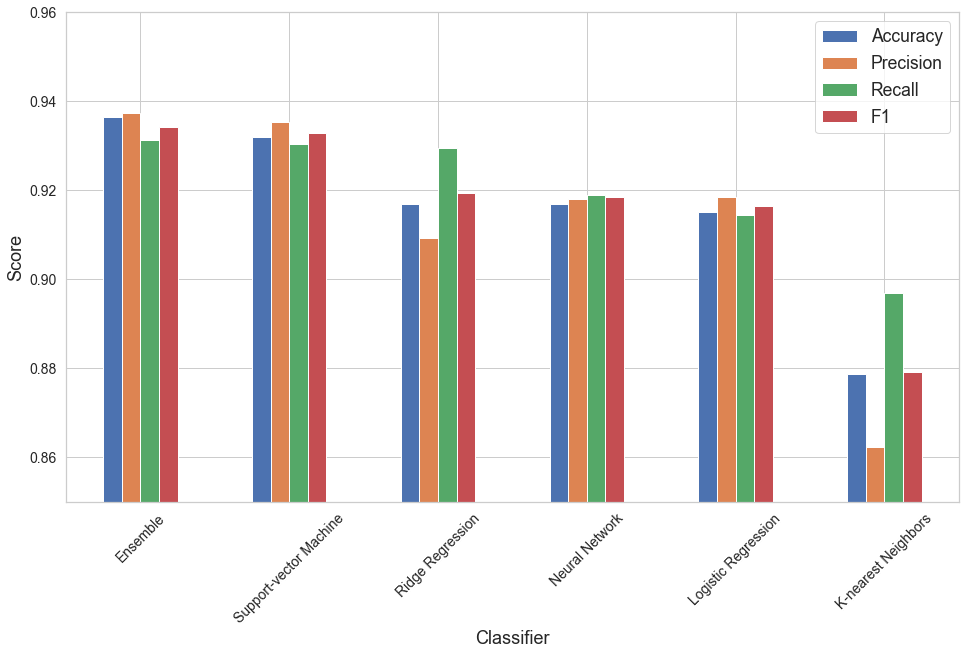

In [86]:
sns.set_theme(style="whitegrid")

ml_results_df.plot(kind="bar", figsize=(16, 9));
plt.ylim(0.85, 0.96);

plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14);

plt.ylabel("Score", fontsize=18);
plt.xlabel("Classifier", fontsize=18);

plt.legend(prop = {"size": 17.5});